# **AvStats - Flight Delay Forecast**

*Iraia Torres, October 2024*

### **Notebook 2 - Modeling and Predictions**
**Important Note**: *Run the EDA notebook before*

1. One hot encoding
2. Correlation Analysis
3. ML techniques - Data Preprocessing
    * Standardization (Z-score)
    * Regularization (Lasso)
    * Multicollinearity (VIF)
4. Modelling
    * Linear Regression
    * Decision Tree
    * Random Forest
5. Hyperparameter Tuning
    * Grid Search CV
    * Randomized Search CV
    * Pareto Front (Learning Curve)
6. ARIMA
    * d (I)
    * p & q (AR and MA)
    * ARIMA
    * SARIMAX
    * Rolling Forecast Origin
7. Neural Networks
8. Model Comparison
9. Residual Analysis

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from datetime import datetime
from sklearn.tree import export_text, plot_tree
from core.config import PARAM_GRID_RF
from core.ML_workflow.OneHotEncoding import OneHotEncoding
from core.ML_workflow.DataPreparation import DataPreparation
from core.ML_workflow.Multicollinearity import Multicollinearity
from core.ML_workflow.ModelTraining import ModelTraining
from core.ML_workflow.ModelComparison import ModelComparison
from core.ML_workflow.ResidualAnalysis import ResidualAnalysis
from core.ML_workflow.ModelEvaluation import cross_validate, evaluate_model
from core.ML_workflow.TimeSeriesAnalysis import TimeSeriesAnalysis
from core.ML_workflow.NeuralNetworks import NeuralNetworks

In [2]:
# Define the path to load the file
file_path = os.path.join("..", "data", "df_merged.csv")
file_path_weather = os.path.join("..", "data", "df_weather.csv")

# Load the DataFrame
df_merged = pd.read_csv(file_path)
df_weather = pd.read_csv(file_path_weather)
print("DataFrames loaded successfully")

DataFrames loaded successfully


In [3]:
df_weather

,route_iata_code,Date,total_flights,departures,arrivals,landed,active,scheduled,total_dep_delay,total_dep_delay_15,...,avg_pres_dep,total_tsun_dep,avg_tavg_arr,total_prcp_arr,avg_snow_arr,avg_wdir_arr,avg_wspd_arr,avg_wpgt_arr,avg_pres_arr,total_tsun_arr
0,AAL-BRU,2023-09-09,5,3,2,1,3,1,576.0,4,...,1016.4,0.0,23.3,0.0,0.0,94.0,4.5,18.5,1017.0,0.0
1,ABJ-BRU,2023-01-01,2,1,1,1,1,0,80.0,2,...,1011.0,0.0,10.1,14.4,0.0,233.0,19.4,44.5,1017.1,0.0
2,ABJ-BRU,2023-01-04,2,1,1,1,1,0,72.0,2,...,1011.4,0.0,11.0,2.2,0.0,244.0,20.4,46.3,1021.0,0.0
3,ABJ-BRU,2023-01-06,2,1,1,1,1,0,88.0,2,...,1012.0,0.0,10.3,0.2,0.0,194.0,24.3,46.3,1010.4,0.0
4,ABJ-BRU,2023-01-08,2,1,1,1,1,0,48.0,2,...,1011.7,0.0,6.7,1.0,0.0,237.0,23.0,46.3,1000.7,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74933,ZTH-BRU,2023-10-14,2,1,1,1,1,0,18.0,0,...,1016.9,0.0,12.1,8.4,0.0,259.0,20.7,48.2,1013.2,0.0
74934,ZTH-BRU,2023-10-15,2,1,1,1,1,0,34.0,2,...,1013.1,0.0,8.3,2.2,0.0,258.0,13.1,29.6,1022.7,0.0
74935,ZTH-BRU,2023-10-21,2,1,1,1,1,0,32.0,2,...,1015.0,0.0,13.4,1.8,0.0,190.0,24.0,51.8,990.2,0.0
74936,ZTH-BRU,2023-10-22,2,1,1,1,1,0,24.0,0,...,1015.8,0.0,12.6,5.8,0.0,219.0,15.0,51.8,1005.6,0.0


### **1. One hot encoding**

In [4]:
data_encoding = OneHotEncoding(df_merged)

# Encode the routes and get the correlation dataframe
df_encoded, corr_df, route_columns = data_encoding.encode_routes()

# Clean data by removing columns with only zeros
df_clean = data_encoding.clean_data()
df_clean

,total_flights,departures,arrivals,landed,active,scheduled,total_dep_delay,total_dep_delay_15,total_on_time_15,short_delay,...,BRU-TLS,BRU-TLV,BRU-TNG,BRU-TUN,BRU-VCE,BRU-VIE,BRU-VLC,BRU-WAW,BRU-YUL,BRU-ZRH
0,42,21,21,18,21,3,1529.0,36,2,6,...,0,0,0,0,0,0,0,0,0,0
1,35,19,16,14,19,2,1206.0,25,7,10,...,0,0,0,0,0,0,0,0,0,0
2,46,22,24,17,22,7,1544.0,37,8,9,...,0,0,0,0,0,0,0,0,0,0
3,37,18,19,15,18,4,1380.0,32,5,5,...,0,0,0,0,0,0,0,0,0,0
4,39,18,21,17,18,2,1624.0,37,2,2,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
751,222,109,113,87,109,26,8083.0,165,44,57,...,0,0,0,0,0,0,0,0,0,2
752,246,120,126,108,120,18,7941.0,177,67,69,...,0,0,0,0,0,0,0,0,0,2
753,270,135,135,130,135,5,6782.0,170,80,100,...,0,0,0,0,0,0,0,0,0,2
754,266,131,135,133,131,2,6157.0,158,104,108,...,0,0,0,0,0,0,0,0,0,2


* df_encoded_weather: same as df_encoded from df_merged but without passengers and daily instead of monthly
* filtered_df: a df for 1 route BRU-MAD without the passengers (just schedule and weather)

In [5]:
data_encoding_weather = OneHotEncoding(df_weather)

# Encode the routes and get the correlation dataframe
df_encoded_weather, corr_df_weather, route_columns_weather = data_encoding_weather.encode_routes()

# Dataframe for a single route (ARIMA, SARIMAX, and Rolling Forecast)
df_encoded_weather['BRU-MAD'] = pd.to_numeric(df_encoded_weather['BRU-MAD'], errors='coerce')
filtered_df = df_encoded_weather[df_encoded_weather['BRU-MAD'] == 2]
filtered_df

,Date,total_flights,departures,arrivals,landed,active,scheduled,total_dep_delay,total_dep_delay_15,total_on_time_15,...,YHZ-BRU,YMX-BRU,YUL-BRU,YYR-BRU,YYZ-BRU,ZAD-BRU,ZAG-BRU,ZAZ-BRU,ZRH-BRU,ZTH-BRU
29993,2023-01-01,16,8,8,8,8,0,242.0,4,8,...,0,0,0,0,0,0,0,0,0,0
29994,2023-01-02,16,8,8,8,8,0,388.0,10,6,...,0,0,0,0,0,0,0,0,0,0
29995,2023-01-03,16,8,8,8,8,0,422.0,14,2,...,0,0,0,0,0,0,0,0,0,0
29996,2023-01-04,16,8,8,8,8,0,286.0,10,6,...,0,0,0,0,0,0,0,0,0,0
29997,2023-01-05,18,9,9,9,9,0,250.0,4,14,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30352,2023-12-27,18,9,9,8,9,1,2143.0,9,8,...,0,0,0,0,0,0,0,0,0,0
30353,2023-12-28,18,9,9,9,9,0,478.0,12,2,...,0,0,0,0,0,0,0,0,0,0
30354,2023-12-29,15,7,8,8,7,0,462.0,15,0,...,0,0,0,0,0,0,0,0,0,0
30355,2023-12-30,14,7,7,7,7,0,260.0,10,4,...,0,0,0,0,0,0,0,0,0,0


### **2. Correlation Analysis**
Correlation analysis helps you understand the relationships between numerical variables. This can inform feature selection, detect multicollinearity, and reveal underlying patterns in your data.
* **Correlation Matrix** and **Heatmap**

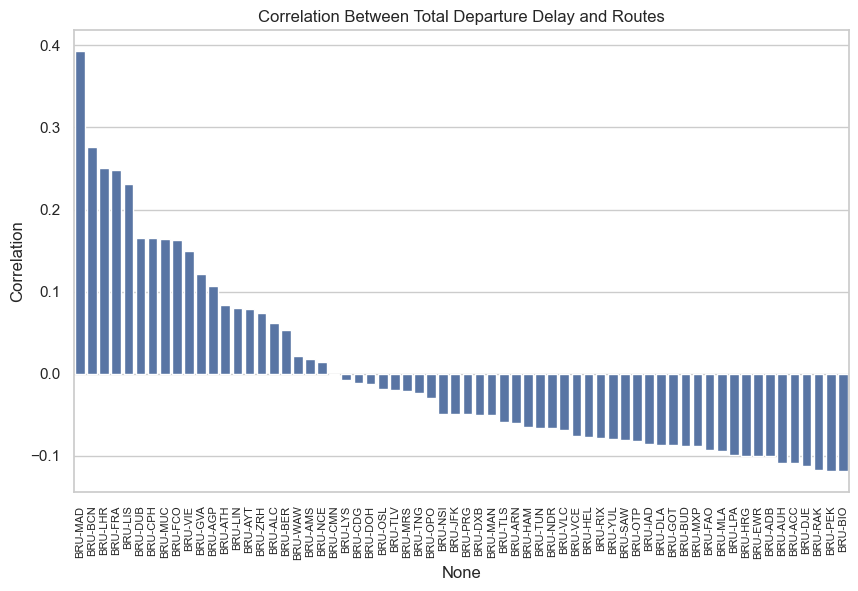

Routes showing the strongest positive correlation with Departure Delays:
 BRU-MAD    0.392701
BRU-BCN    0.275766
BRU-LHR    0.250346
BRU-FRA    0.248473
BRU-LIS    0.231481
Name: total_dep_delay_15, dtype: float64


In [6]:
# Calculate the correlation matrix
correlation_matrix = corr_df.corr()

# Extract only the correlation of 'total_dep_delay' with the routes
total_dep_delay_corr = correlation_matrix['total_dep_delay_15'][route_columns].sort_values(ascending=False)

# Filter for only positive correlations
positive_corr = total_dep_delay_corr[total_dep_delay_corr > 0.2]

# Plot the correlation between total_dep_delay and the route codes
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(x=total_dep_delay_corr.index, y=total_dep_delay_corr.values)
plt.xticks(rotation=90, fontsize=8)
plt.title('Correlation Between Total Departure Delay and Routes', fontsize=12)
plt.ylabel('Correlation')
plt.show()

# Print correlation values for better inspection
print('Routes showing the strongest positive correlation with Departure Delays:\n',positive_corr)

* **Positive correlation with delays**: More likely to experience delays. A high positive correlation indicates that delays are more frequent on that route.
* **Negative correlation with delays**: Less likely to be delayed. These routes tend to run on time, indicating more consistent operational conditions or favorable factors.

C:\Testing\Anaconda\envs\dtsc\lib\site-packages\pandas\core\groupby\grouper.py:381: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  ax = Index(obj[key], name=key)


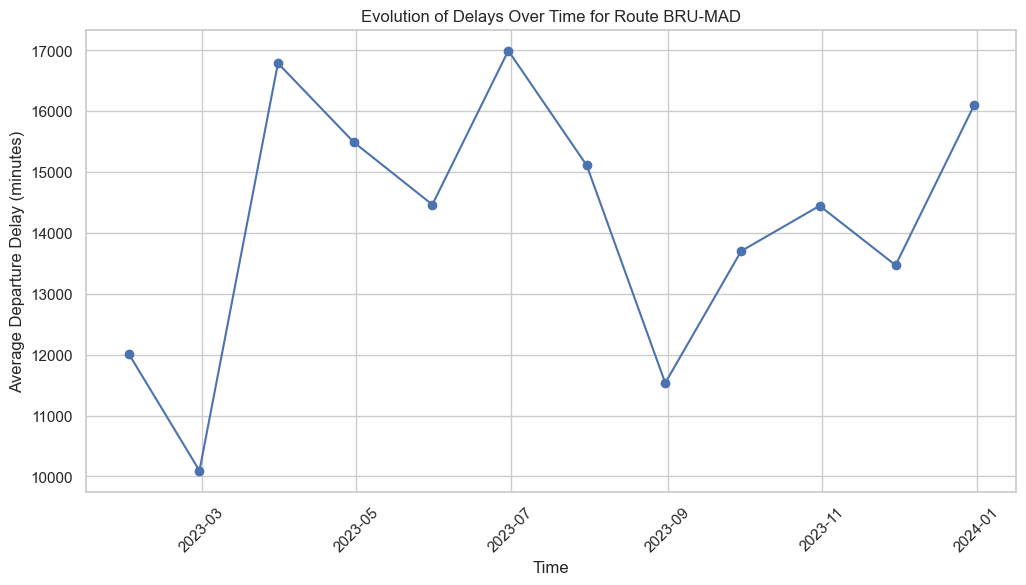

In [7]:
# Filter the dataframe for the specific route to analyze
route_code = 'BRU-MAD' 
df_route = df_merged[df_merged['route_iata_code'] == route_code]
df_route = df_route.infer_objects()

# Convert the 'Month' column to datetime if it's not already
df_route.loc[:, 'Month'] = pd.to_datetime(df_route['Month'])

# Resample the data to a monthly frequency, averaging only the numeric columns (e.g., dep_delay)
df_route_monthly = df_route.resample('ME', on='Month').mean(numeric_only=True)

# Plot the delay over time
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 6))
plt.plot(df_route_monthly.index, df_route_monthly['total_dep_delay'], marker='o', linestyle='-')
plt.title(f'Evolution of Delays Over Time for Route {route_code}')
plt.xlabel('Time')
plt.ylabel('Average Departure Delay (minutes)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [8]:
# Get only the numeric columns
numeric_columns = df_clean.select_dtypes(include=['number']).columns.tolist()

# Print the list of numeric columns
print(numeric_columns)

['total_flights', 'departures', 'arrivals', 'landed', 'active', 'scheduled', 'total_dep_delay', 'total_dep_delay_15', 'total_on_time_15', 'short_delay', 'medium_delay', 'long_delay', 'total_calc_sft', 'total_calc_aft', 'total_flight_distance_km', 'commercial', 'private', 'cargo', 'morning_dep', 'afternoon_dep', 'evening_dep', 'morning_arr', 'afternoon_arr', 'evening_arr', 'avg_tavg_dep', 'total_prcp_dep', 'avg_wdir_dep', 'avg_wspd_dep', 'avg_wpgt_dep', 'avg_pres_dep', 'avg_tavg_arr', 'total_prcp_arr', 'avg_snow_arr', 'avg_wdir_arr', 'avg_wspd_arr', 'avg_wpgt_arr', 'avg_pres_arr', 'total_tsun_arr', 'total_passengers', 'BRU-ACC', 'BRU-ADB', 'BRU-AGP', 'BRU-ALC', 'BRU-AMS', 'BRU-ARN', 'BRU-ATH', 'BRU-AUH', 'BRU-AYT', 'BRU-BCN', 'BRU-BER', 'BRU-BIO', 'BRU-BUD', 'BRU-CDG', 'BRU-CMN', 'BRU-CPH', 'BRU-DJE', 'BRU-DLA', 'BRU-DOH', 'BRU-DUB', 'BRU-DXB', 'BRU-EWR', 'BRU-FAO', 'BRU-FCO', 'BRU-FRA', 'BRU-GOT', 'BRU-GVA', 'BRU-HAM', 'BRU-HEL', 'BRU-HRG', 'BRU-IAD', 'BRU-JFK', 'BRU-LHR', 'BRU-LIN', '

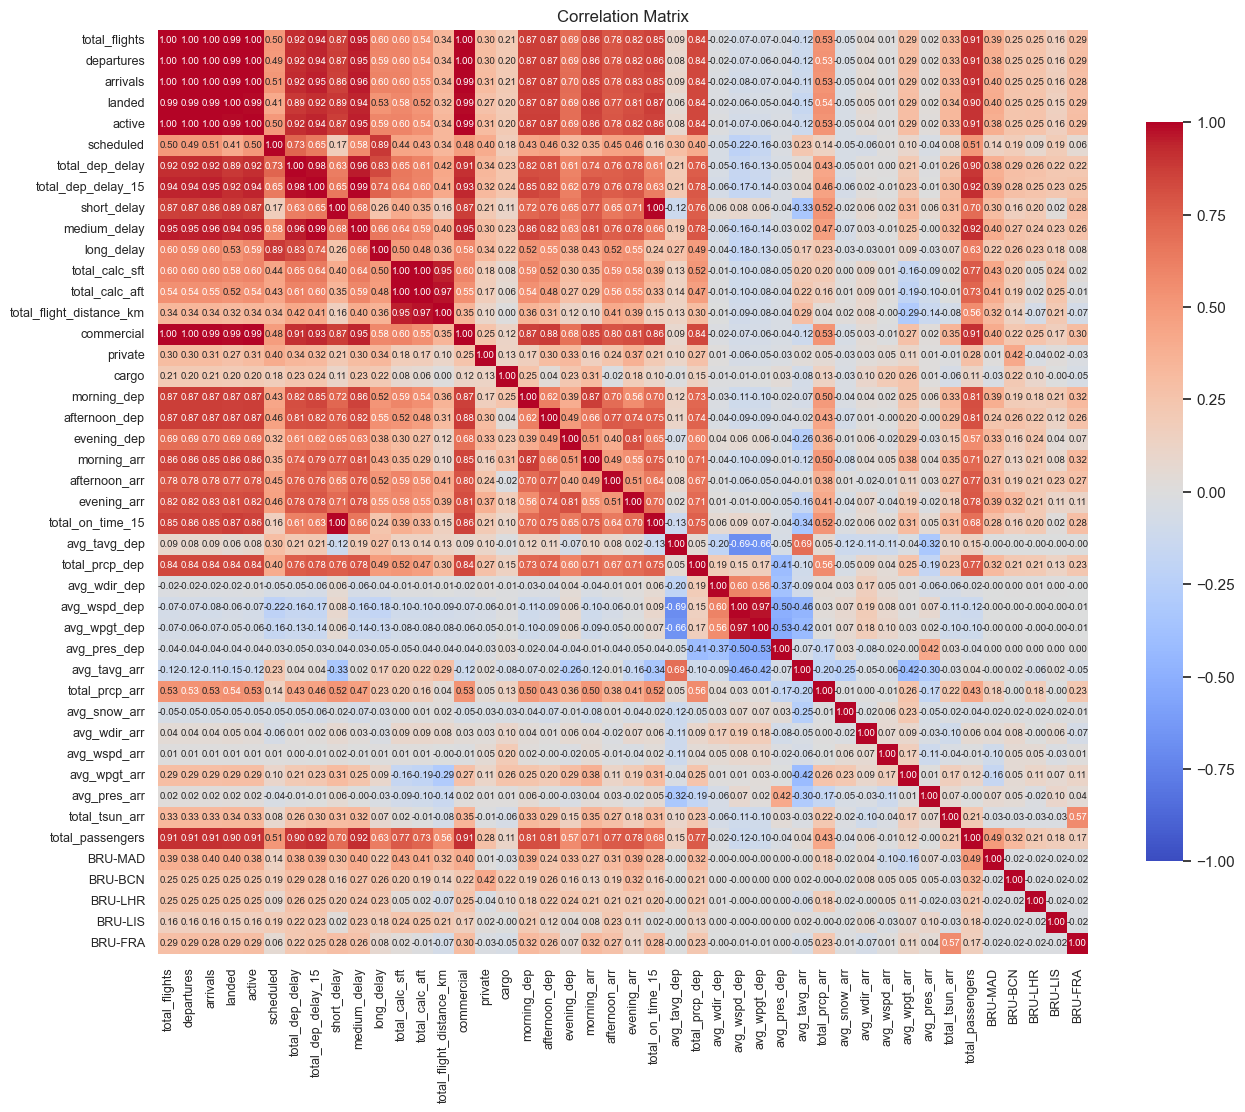

In [9]:
# Select the relevant columns for correlation analysis
corr_columns = ['total_flights', 'departures', 'arrivals', 'landed', 'active', 'scheduled', 'total_dep_delay', 'total_dep_delay_15', 'short_delay', 'medium_delay', 'long_delay', 'total_calc_sft', 'total_calc_aft', 'total_flight_distance_km', 'commercial', 'private', 'cargo', 'morning_dep', 'afternoon_dep', 'evening_dep', 'morning_arr', 'afternoon_arr', 'evening_arr', 'total_on_time_15', 'avg_tavg_dep', 'total_prcp_dep', 'avg_wdir_dep', 'avg_wspd_dep', 'avg_wpgt_dep', 'avg_pres_dep', 'avg_tavg_arr', 'total_prcp_arr', 'avg_snow_arr', 'avg_wdir_arr', 'avg_wspd_arr', 'avg_wpgt_arr', 'avg_pres_arr', 'total_tsun_arr', 'total_passengers', 'BRU-MAD', 'BRU-BCN', 'BRU-LHR', 'BRU-LIS', 'BRU-FRA']

corr_df = df_clean[corr_columns].dropna() # Drop any rows with NaN values
corr_df = corr_df.loc[:, (corr_df[corr_columns] != 0).any(axis=0)].dropna()
corr_df.reset_index(drop=True, inplace=True)  # Reset the index after dropping rows
correlation_matrix = corr_df.corr() # Perform the correlation analysis

plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=True, 
            fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, annot_kws={"size": 7}, 
            cbar_kws={'shrink': 0.8})

# Set the font size for the axis labels
plt.xticks(fontsize=9)  # X-axis labels
plt.yticks(fontsize=9)  # Y-axis labels

# Title and adjustments
plt.title('Correlation Matrix', fontsize=12)
plt.show()

* The target variable should be kept in the DataFrame after the VIF process but excluded from the calculations when identifying features with high multicollinearity since the target variable is needed for the modeling stage.

### **3. Machine Learning Techniques - Data Preprocessing**

#### **3.1. Standardization - Z-score normalization**

**Purpose**: To scale features so that they have a mean of 0 and a standard deviation of 1, effectively transforming the data to a standard normal distribution.

**How it works**: The formula for standardization is:

    Xstd = (X − μ) / σ

where:

    X is the feature value,
    μ is the mean of the feature,
    σ is the standard deviation of the feature.

**When to use**:
* When the data follows a normal distribution (or approximately) or when  working with algorithms that assume data is normally distributed, like linear regression, logistic regression, or principal component analysis (PCA).
* It is less sensitive to outliers than normalization but still can be affected if there are extreme outliers.


In [10]:
# Standardize data
#df_dropped = filtered_df.drop(filtered_df.columns[:1], axis=1)
data_prep = DataPreparation(df_clean, 'total_dep_delay') # df_clean
scaled_df, target_variable = data_prep.standardize_data()

# Check the mean and standard deviation
print("Means of scaled features:\n", scaled_df.mean())
print("Standard deviations of scaled features:\n", scaled_df.std())

Means of scaled features:
 total_flights   -1.080852e-16
departures      -1.409807e-17
arrivals         1.879743e-17
landed           7.518971e-17
active           4.934325e-17
                     ...     
BRU-VIE          9.398713e-18
BRU-VLC          9.398713e-18
BRU-WAW          9.398713e-18
BRU-YUL          9.398713e-18
BRU-ZRH         -2.819614e-17
Length: 102, dtype: float64
Standard deviations of scaled features:
 total_flights    1.000662
departures       1.000662
arrivals         1.000662
landed           1.000662
active           1.000662
                   ...   
BRU-VIE          1.000662
BRU-VLC          1.000662
BRU-WAW          1.000662
BRU-YUL          1.000662
BRU-ZRH          1.000662
Length: 102, dtype: float64


In [11]:
scaled_df

,total_flights,departures,arrivals,landed,active,scheduled,total_dep_delay_15,total_on_time_15,short_delay,medium_delay,...,BRU-TLS,BRU-TLV,BRU-TNG,BRU-TUN,BRU-VCE,BRU-VIE,BRU-VLC,BRU-WAW,BRU-YUL,BRU-ZRH
0,-1.020906,-1.017989,-1.023053,-1.011953,-1.027484,-0.457786,-0.880541,-1.057330,-1.008000,-0.892910,...,-0.127,-0.121512,-0.127,-0.127,-0.127,-0.127,-0.127,-0.127,-0.127,-0.127000
1,-1.079034,-1.051632,-1.104999,-1.081155,-1.061006,-0.606705,-1.019600,-0.954226,-0.932334,-1.033415,...,-0.127,-0.121512,-0.127,-0.127,-0.127,-0.127,-0.127,-0.127,-0.127,-0.127000
2,-0.987690,-1.001168,-0.973885,-1.029254,-1.010723,0.137887,-0.867899,-0.933606,-0.951250,-0.892910,...,-0.127,-0.121512,-0.127,-0.127,-0.127,-0.127,-0.127,-0.127,-0.127,-0.127000
3,-1.062426,-1.068453,-1.055831,-1.063854,-1.077767,-0.308868,-0.931108,-0.995468,-1.026916,-0.921011,...,-0.127,-0.121512,-0.127,-0.127,-0.127,-0.127,-0.127,-0.127,-0.127,-0.127000
4,-1.045818,-1.068453,-1.023053,-1.029254,-1.077767,-0.606705,-0.867899,-1.057330,-1.083665,-0.906961,...,-0.127,-0.121512,-0.127,-0.127,-0.127,-0.127,-0.127,-0.127,-0.127,-0.127000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
751,0.473826,0.462269,0.484764,0.181768,0.447464,2.967337,0.750244,-0.191260,-0.043263,0.413782,...,-0.127,-0.121512,-0.127,-0.127,-0.127,-0.127,-0.127,-0.127,-0.127,7.874008
752,0.673124,0.647302,0.697825,0.545074,0.631832,1.775990,0.901945,0.283017,0.183734,0.722892,...,-0.127,-0.121512,-0.127,-0.127,-0.127,-0.127,-0.127,-0.127,-0.127,7.874008
753,0.872421,0.899619,0.845328,0.925681,0.883244,-0.159949,0.813453,0.551086,0.770143,0.933649,...,-0.127,-0.121512,-0.127,-0.127,-0.127,-0.127,-0.127,-0.127,-0.127,7.874008
754,0.839205,0.832334,0.845328,0.977582,0.816201,-0.606705,0.661752,1.045983,0.921475,0.765044,...,-0.127,-0.121512,-0.127,-0.127,-0.127,-0.127,-0.127,-0.127,-0.127,7.874008


* Means close to 0: The means are extremely close to zero, indicated by very small values like 7.518971e-17, which is essentially 0. This is expected after standardization.
* Standard Deviations close to 1: The standard deviations are approximately 1 (1.000662), which confirms that all features have been scaled to a unit standard deviation.

#### **3.2. Regularization - Lasso**
**Purpose**: To prevent overfitting by adding a penalty to the loss function of the model, effectively discouraging the model from becoming too complex.

**How it works**:
* **L1 regularization (Lasso)**: Adds a penalty term proportional to the absolute value of the coefficients. It can drive some coefficients to zero, effectively performing feature selection.
* **L2 regularization (Ridge)**: Adds a penalty term proportional to the square of the coefficients, encouraging smaller coefficients but not necessarily driving them to zero.
* **ElasticNet** combines both L1 and L2 penalties.

**When to use**:
* When the model is overfitting, meaning it performs well on training data but poorly on test data.
* It is used to constrain the complexity of a model, especially when there are too many features or when there’s a risk of multicollinearity.

C:\Testing\Anaconda\envs\dtsc\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.167e+06, tolerance: 8.020e+05
  model = cd_fast.enet_coordinate_descent(


Important features according to Lasso regression: total_dep_delay_15    1401.572388
total_flights          929.211466
long_delay             729.691261
landed                 208.782350
scheduled              168.335484
evening_arr            163.063851
morning_dep             99.276705
arrivals                75.000031
total_calc_sft          66.256622
avg_wpgt_dep            64.017247
BRU-AMS                 43.615736
avg_tavg_arr           -43.877447
afternoon_dep          -46.514580
BRU-IAD                -51.662751
BRU-PEK                -57.887908
cargo                  -76.031588
avg_wpgt_arr          -111.561158
avg_wspd_dep          -112.448156
total_on_time_15      -113.751131
short_delay           -188.743915
dtype: float64


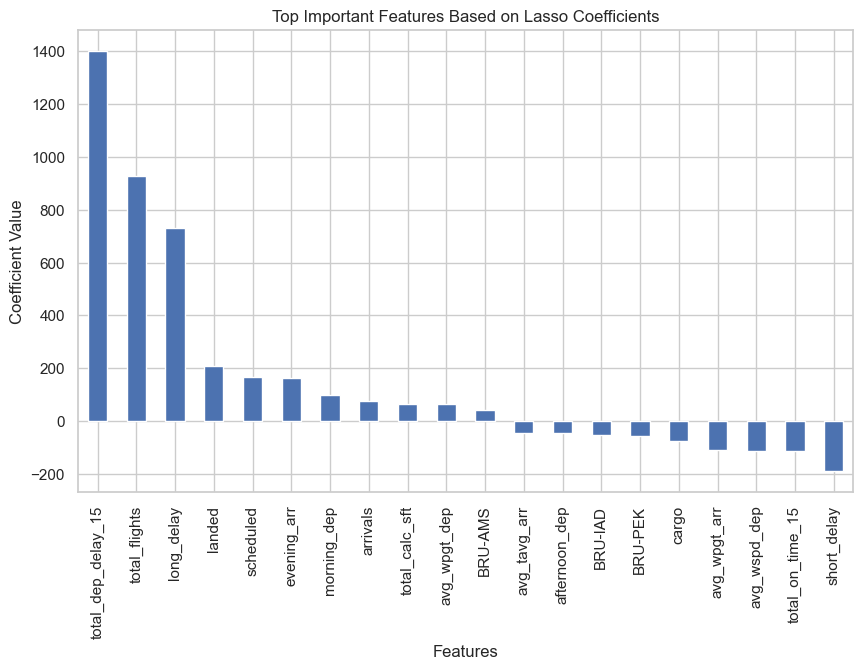

In [12]:
important_features_df, important_features = data_prep.select_important_features()

# The important features
print(f"Important features according to Lasso regression: {important_features}")

# Visualize the top 10 important features
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
important_features.plot(kind='bar')
plt.title('Top Important Features Based on Lasso Coefficients')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.show()

* The coefficient indicates the strength of the relationship between the feature and the target variable. 
* The higher the absolute value, the more influence that feature has on the target.
* Example **landed: 1600.493731**: This suggests that landed has a strong positive influence on the target variable (total_dep_delay). As the value of landed increases, the predicted value of total_dep_delay is likely to increase by approximately 1600 minutes.

#### **3.3. Multicollinearity - VIF**

In [13]:
# Initialize the Multicollinearity class
multicollinearity = Multicollinearity(scaled_df, target_variable, verbose=False) # False to suppress output

# Remove features with high VIF values
print("Removing high VIF features...")
df_vif_cleaned, final_features = multicollinearity.remove_high_vif_features()

Removing high VIF features...


C:\Testing\Anaconda\envs\dtsc\lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


All remaining features have VIF below the threshold.
Final VIF values after feature removal:
                      feature   VIF
0                  scheduled  1.73
1           total_on_time_15  4.13
2   total_flight_distance_km  2.20
3               avg_tavg_dep  4.77
4             total_prcp_dep  6.81
5               avg_wdir_dep  1.64
6               avg_wpgt_dep  5.38
7               avg_pres_dep  3.47
8               avg_tavg_arr  3.49
9             total_prcp_arr  1.69
10              avg_snow_arr  1.20
11              avg_wdir_arr  1.11
12              avg_wspd_arr  1.09
13              avg_wpgt_arr  1.81
14              avg_pres_arr  1.60
15            total_tsun_arr  1.20
16          total_passengers  5.77


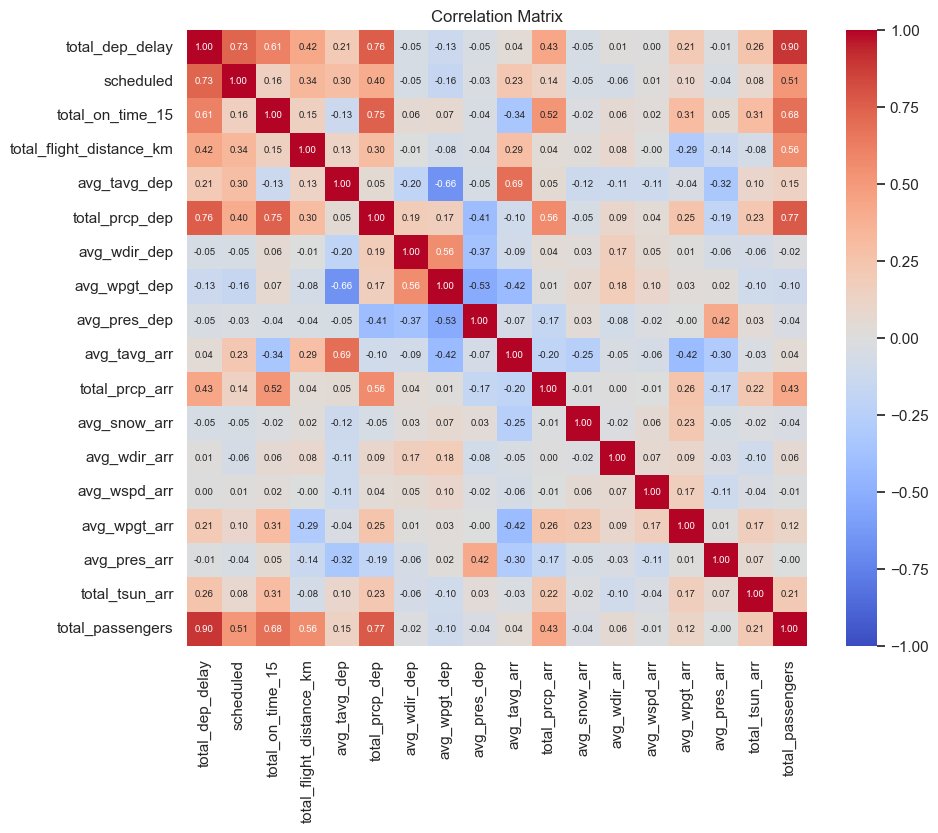

In [14]:
correlation_matrix = df_vif_cleaned.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, annot_kws={"size": 7}) 
plt.title('Correlation Matrix')
plt.show()

### **4. Modelling & Predicting**
First, linear regression will be used since it provides a **quick initial understanding** of the relationship between the predictors (independent) and the target variable (dependent). It's useful to detect **multicollinearity** (correlation between features) and to see if a **simple model** is enough to get good results before moving to complex ones, such as Random Forest.

In [15]:
# Split the data into features (X) and target (y)
x = df_vif_cleaned.drop(columns=['total_dep_delay'])  # drop the target variable
y = df_vif_cleaned['total_dep_delay']

# Training and testing data based on features
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
model_training = ModelTraining(x_train, y_train, x_test, y_test)

In [16]:
# Cross-validation (scores for each fold in a 5-fold cross-validation)
cv = cross_validate(x_train, y_train)
print("Cross Validation:", cv)

Cross Validation: [0.91228729 0.93188793 0.91204997 0.93207149 0.93184404]


#### **4.1. Linear Regression**
* **Dep. Variable**. The dependent variable we want to predict (it's total_dep_delay).
* **Model**. The type of model used, which is OLS (Ordinary Least Squares).
* **Method**. Least Squares, which is the standard approach for fitting a linear regression model.
* **No. Observations**. There are 604 data points (rows) in the dataset.
* **Df Residuals**. The degrees of freedom for residuals (observations minus the number of estimated parameters). Here, it's 586.
* **Df Model**. The degrees of freedom for the model (the number of predictors), which is 17 (including the intercept).

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                     473.0
Date:                Mon, 06 Jan 2025   Prob (F-statistic):               0.00
Time:                        17:06:12   Log-Likelihood:                -4939.6
No. Observations:                 604   AIC:                             9915.
Df Residuals:                     586   BIC:                             9995.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4364.6868     35.738    122.131      0.0

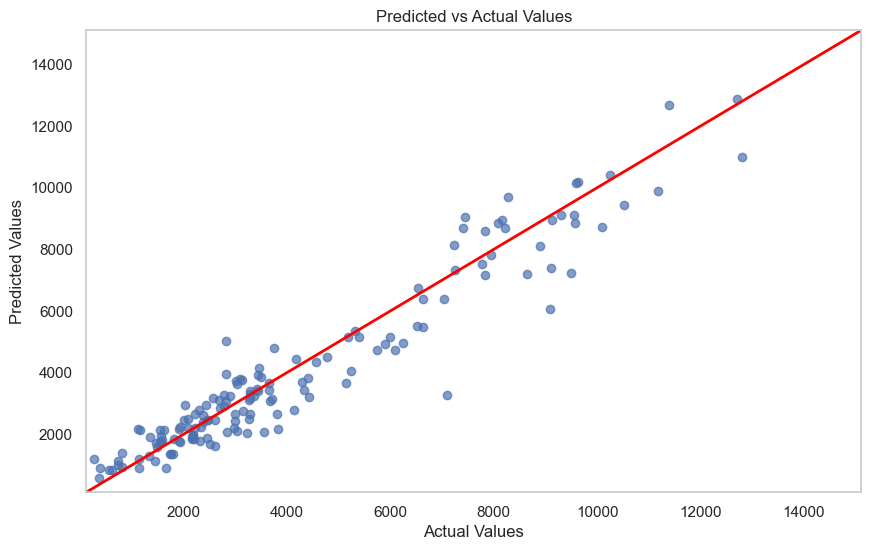

Mean Absolute Error (MAE): 620.80min.
Mean Absolute Percent Error (MAPE): 21.54%
Root Mean Squared Error (RMSE): 844.90min.


In [17]:
# Train a Linear Regression model and generate predictions
linear_model, linear_predictions = model_training.train_linear_model()
print(linear_model.summary())

# Plot results
model_training.plot_model()

# Model Evaluation
linear_residuals = y_test - linear_predictions
linear_mae, linear_mape, linear_rmse = evaluate_model(y_test, linear_predictions, linear_residuals)

#### **4.2. Decision Tree**

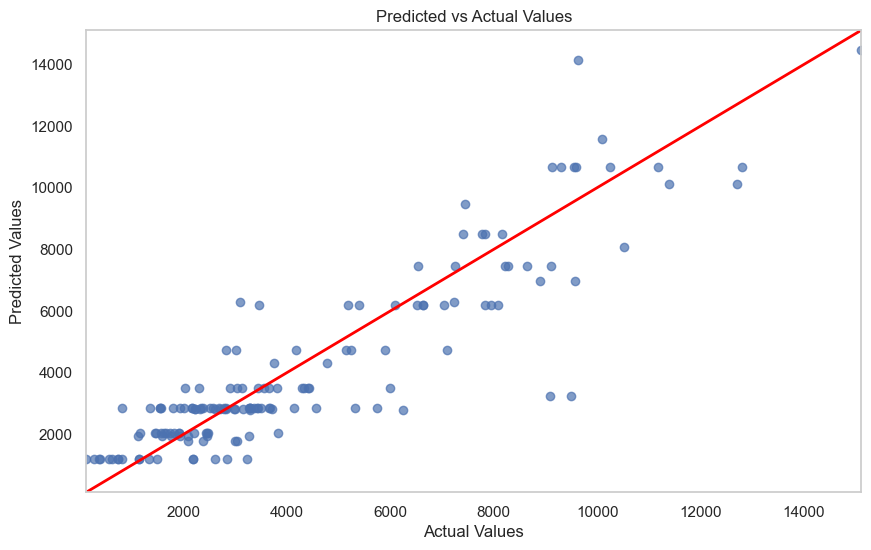

Mean Absolute Error (MAE): 969.71min.
Mean Absolute Percent Error (MAPE): 38.61%
Root Mean Squared Error (RMSE): 1368.76min.


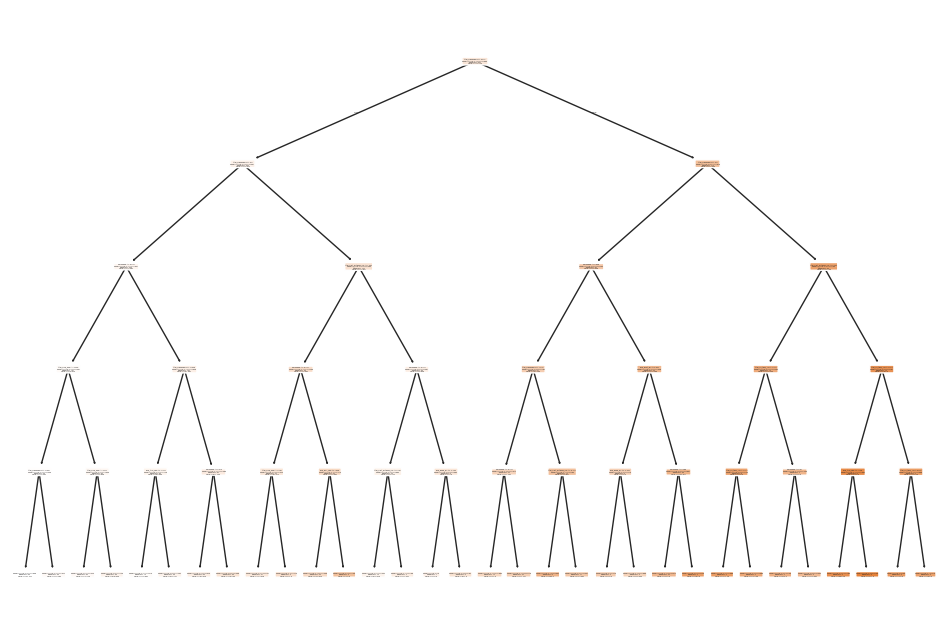

|--- total_passengers <= 0.81
|   |--- total_passengers <= 0.00
|   |   |--- scheduled <= -0.53
|   |   |   |--- total_prcp_dep <= -0.60
|   |   |   |   |--- total_passengers <= -0.62
|   |   |   |   |   |--- value: [1197.38]
|   |   |   |   |--- total_passengers >  -0.62
|   |   |   |   |   |--- value: [1933.48]
|   |   |   |--- total_prcp_dep >  -0.60
|   |   |   |   |--- total_prcp_dep <= -0.27
|   |   |   |   |   |--- value: [2046.15]
|   |   |   |   |--- total_prcp_dep >  -0.27
|   |   |   |   |   |--- value: [2828.53]
|   |   |--- scheduled >  -0.53
|   |   |   |--- total_passengers <= -0.54
|   |   |   |   |--- avg_tavg_dep <= -1.02
|   |   |   |   |   |--- value: [1779.87]
|   |   |   |   |--- avg_tavg_dep >  -1.02
|   |   |   |   |   |--- value: [2859.14]
|   |   |   |--- total_passengers >  -0.54
|   |   |   |   |--- scheduled <= 0.21
|   |   |   |   |   |--- value: [3489.65]
|   |   |   |   |--- scheduled >  0.21
|   |   |   |   |   |--- value: [4728.10]
|   |--- total_passe

In [18]:
decision_model, decision_predictions = model_training.train_decision_tree()

# Plot results
model_training.plot_model()

# Evaluate the model
decision_residuals = y_test - decision_predictions
decision_mae, decision_mape, decision_rmse = evaluate_model(y_test, decision_predictions, decision_residuals)

# Visualize the decision tree
plt.figure(figsize=(12, 8))
plot_tree(decision_model, feature_names=x.columns, filled=True, rounded=True)
plt.show()

# Export the decision tree structure as text
print(export_text(decision_model, feature_names=list(x.columns)))

#### **4.3. Random Forest**

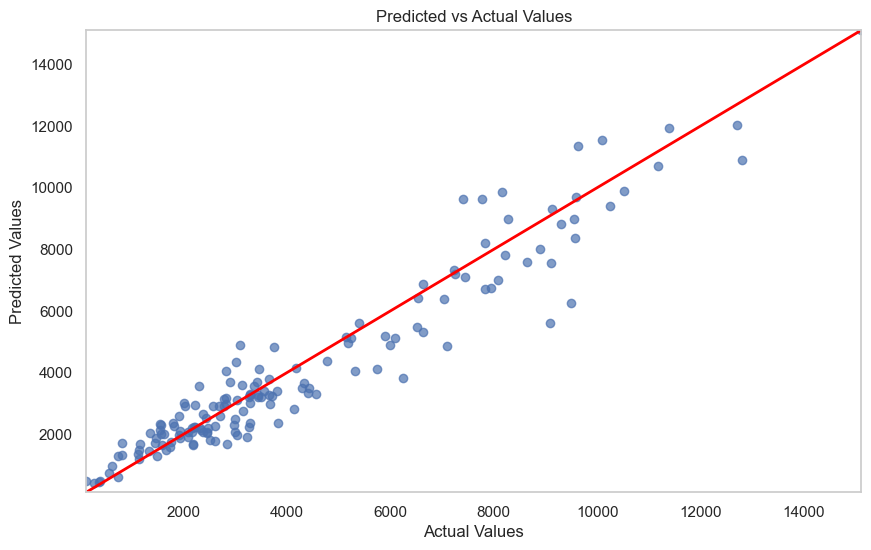

Mean Absolute Error (MAE): 631.34min.
Mean Absolute Percent Error (MAPE): 20.81%
Root Mean Squared Error (RMSE): 874.94min.


In [19]:
# Train a Random Forest model
random_forest_model, random_forest_predictions = model_training.train_random_forest()

# Plot the model results
model_training.plot_model()

# Model Evaluation
random_forest_residuals = y_test - random_forest_predictions
random_forest_mae, random_forest_mape, random_forest_rmse = evaluate_model(y_test, random_forest_predictions, random_forest_residuals)

### **5. Hyperparameter Tuning**
* RandomForestRegressor
* Hyperparameter Tuning: Helps to identify the best combination of hyperparameters that optimize model performance. 
    * **Grid Search CV**. Tests all combinations.
    * **Randomized Search CV**. Tests random samples.

#### **5.1. Grid Search**

**Candidates**. It systematically tries every possible combination of the parameters in the provided param_grid. Since param_grid_rf has four hyperparameters:
            
        n_estimators: 3 options
        max_depth: 4 options
        min_samples_split: 3 options
        min_samples_leaf: 3 options

There are *3 x 4 x 3 x 3 = 108* possible combinations.

**Total Fits**. With 5-fold cross-validation (cv=5), Grid Search will evaluate each of the combinations 5 times, leading to a total of *108 x 5 = 540* fits.

In [24]:
# Perform Grid Search and evaluate
grid_tuning_model, grid_tuning_parameters, grid_predictions, sample_sizes, grid_train_errors, grid_test_errors = model_training.tune_and_evaluate(
    param_grid=PARAM_GRID_RF,
    verbose=0,
    search_type='grid',
    log_scale=True  # Use log scale for sample sizes
)

print(f"Best Parameters Grid Search: {grid_tuning_parameters}")

# Model Evaluation
grid_cv_mae, grid_cv_mape, grid_cv_rmse = evaluate_model(y_test, grid_predictions)

Best Parameters Grid Search: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Mean Absolute Error (MAE): 628.31min.
MAPE not available
Root Mean Squared Error (RMSE): 871.49min.


#### **5.2. Random Search**

**Candidates**. Randomized Search doesn’t try all combinations but instead samples a subset from the provided parameter space. In this case:

        n_iter = 10
        
Meaning it will randomly sample *10 different* combinations from the parameter grid.

**Total Fits**. With 5-fold cross-validation, Randomized Search will evaluate each of the combinations 5 times, resulting in *10 x 5 = 50* total fits.

In [25]:
random_tuning_model, random_tuning_parameters, random_predictions, random_sample_sizes, random_grid_train_errors, random_grid_test_errors = model_training.tune_and_evaluate(
    param_grid=PARAM_GRID_RF,
    verbose=0,
    search_type='random',
    n_iter=10
)

print(f"Best Parameters Random Search: {random_tuning_parameters}")

# Model Evaluation
random_cv_mae, random_cv_mape, random_cv_rmse = evaluate_model(y_test, random_predictions)

Best Parameters Random Search: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 30}
Mean Absolute Error (MAE): 633.75min.
MAPE not available
Root Mean Squared Error (RMSE): 879.54min.


#### **5.3. Pareto Front Learning Curve (Grid Search)**

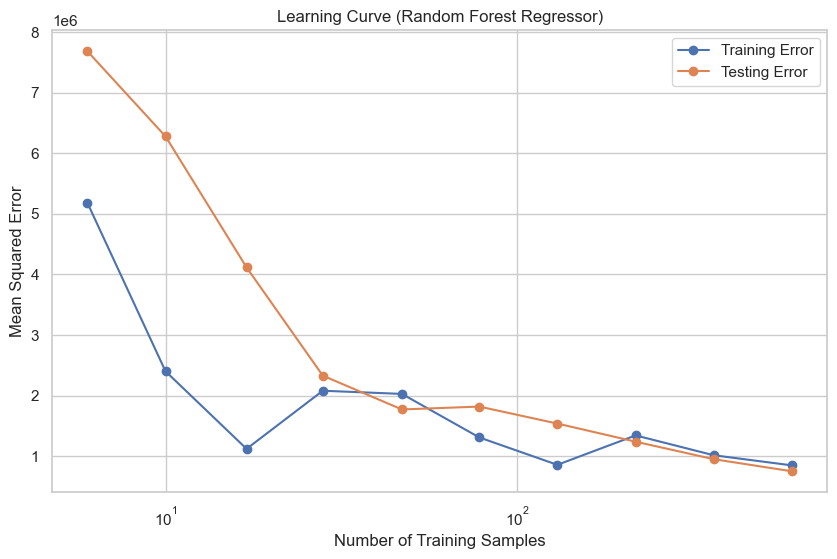

In [26]:
# Plotting the Learning Curve
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
plt.plot(sample_sizes, grid_train_errors, label="Training Error", marker='o')
plt.plot(sample_sizes, grid_test_errors, label="Testing Error", marker='o')
plt.title(f"Learning Curve (Random Forest Regressor)")
plt.xlabel("Number of Training Samples")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.grid(True)
plt.xscale('log')
plt.show()

### **6. ARIMA**
ARIMA (AutoRegressive Integrated Moving Average) is a statistical model suited for time series data. If the dataset has time-related features (like delays or flight frequencies over time), ARIMA can be used to predict future values.

* **Prepare Time Series Data**: Ensure the data is sorted by time. Create a dataset with a single time-dependent feature (e.g., delays, flight counts).
* **Build ARIMA Model**: Fit the model by using statsmodels.
    * p = AutoRegressive part (AR, **Auto Regressive** timeseries forecasting model)
    * d = Differencing (I, **Integrated**)
    * q = Moving Average part (MA, **Moving Average**)


**Regression**. We are trying to predict something based on other things. 

**Auto Regression**. We are trying to predict something based on its past values. There could be some pattern in our historical data, and if we can capture that pattern, we can get a much stronger prediction.
* Data we are trying to predict.
    * $f_t$ = Quantity of delayed flights this month.
* Data available to predict $f_t$ with => **Lags**.
    * $f_{t-1}$ = Quantity of delayed flights last month.
    * $f_{t-12}$ = Quantity of delayed flights 12 months ago.

The model should not include every single lag (from 1 to 12) because it will get a lot of statistical issues such as overfitting. That's why we need to figure out which lags are important. How? **PACF chart** (Partial Auto Correlation Function). The model should only include the lags whose direct effects are high either positive or negative. If they are 0 or close to 0, they should not be included. Because they don't have a direct correlation with delays.

e.g. $f_{t-3}$ => direct effect on $f_{t}$ and this means it removes the effect of $f_{t-1}$ and $f_{t-2}$ the delays 1 and 2 months ago.

* $avgf_t$ = Average delayed flights this month.
* $avgf_{t-1}$ = Average delayed flights 1 month ago.
* $avgf_{t-2}$ = Average delayed flights 2 months ago.

* **ACF chart (Auto Correlation Function)**: Takes into account both the direct and indirect effects. With ACF might seem like a good predictor since the pearson correlation is high. But it might be high because of the indirect effects and therefore the direct effect has little to no correlation.
    * E.g. corr($avgf_{t-2}$, $avgf_t$) 
        * Direct: $avgf_{t-2}$ => $avgf_t$
        * Indirect: $avgf_{t-2}$ => $avgf_{t-1}$ => $avgf_t$


* **PACF chart (Partial Auto Correlation Function)**: Only takes into account the direct effect. Why? To see whether the delayed flights on $avgf_{t-2}$ is a good predictor of $avgf_t$. 

**Integrated**: Used to remove trends and make the data stationary. Instead of predicting the **time series** itself, the model predicts **differences of the time series**, from one timestamp to the previous timestamp. This is done by creating a time series **$z_t = a_{t+1} - a_t$** which takes the number of delayed flights in one month - the number of delayed flights from the previous month.

**Moving Average**: **$\hat{f_t} = u + o_1 e_{t-1}$** => Predicted number of flights ($\hat{f_t}$) = mean (u) + coefficient ($o_1$) * the error from the previous month ($e_t$).
* u = constant (every month we have the same amount of delayed flights)
* $f_t$ = changes (how many delayed flights we should have had that month)
* $o_1$ = some coefficient (such as 0.5)
* $e_t(u_e, o_e)$ = the error (the wrong amount delayed flights (mean of the error, standard deviation of the error))

e.g. 10($\hat{f_t}$) -2($e_t$) = 8($f_t$) => 10 + (-2($e_t$) / 2($o_1$)) = 9($\hat{f_t}$) +1($e_t$) = 10($f_t$) => etc.

The model is explaining that we will always have the same amount of delayed flights, but we will adjust that by 50% (coefficient) of whatever the error was last month. We are taking information about how wrong we were in the previous time period (t) to make a better estimate for the current time period (t - 1). We have our average (10), which it's moving around, but it's always centered at the average.

#### **6.1. Choosing d (Differencing)**

It's used to make the time series stationary by for example, removing trends and seasonality. 
* Check stationarity with a Dickey-Fuller test. 
    * If the p-value is less than 0.05, the data is likely stationary. (d = 0)
    * If the test result indicates non-stationarity, apply differencing. (d = 1) or (d = 2)
* Determine d:
    * First trying d = 1 (first difference), which is common for time series with a trend.
    * If the data still shows a trend, try d = 2 (second difference), though higher differencing values are rare.

In [20]:
df_arima = filtered_df.copy()

# Convert 'Date' to datetime and print the range and intervals
df_arima['Date'] = pd.to_datetime(df_arima['Date'])

# Set 'Date' as the index
df_arima.set_index('Date', inplace=True)

# Resample and forward fill missing data
df_arima = df_arima.resample('D').ffill()  # Or use bfill, depending on your needs

# Reset the index to a regular column
df_arima.reset_index(inplace=True)

In [21]:
train_end = datetime(2023, 6, 30)
test_end = datetime(2023, 12, 31)
start_date = datetime(2023, 1, 1)
end_date = datetime(2023, 12, 31)

arima_analysis = TimeSeriesAnalysis(df_arima, start_date, end_date, train_end, test_end, column='total_dep_delay', date_column='Date')
differenced_data, is_stationary = arima_analysis.check_stationarity()

if is_stationary:
    print("The data is stationary and ready for modeling.")
else:
    print("The data is still non-stationary after differencing.")

- ADF Test p-value (original): 0.00042812295842722156
Series is stationary after 0 differencing -> d = 0.
The data is stationary and ready for modeling.


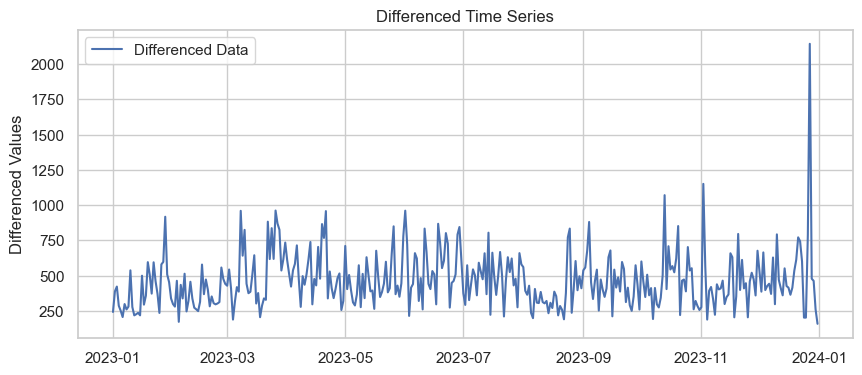

In [22]:
plt.figure(figsize=(10, 4))
plt.plot(differenced_data, label='Differenced Data')
plt.title("Differenced Time Series")
plt.ylabel("Differenced Values")
plt.legend()
plt.show()


#### **6.2. Choosing p (AR Order) and q (MA Order)**

The best practice is to start with a small p and q, and gradually increase them.

**Autoregressive (AR) order (p).**
* AR it's the relationship between the current observation and previous observations.
* This can be determined by analyzing the Partial Autocorrelation Function (PACF) plot.
    * If the PACF plot cuts off at some lag, this could be an estimation for p. (p = cutoff lag at PACF)

**Moving Average (MA) order (q).**
* MA  it's the relationship between the current observation and the residual errors from previous time steps.
* This can be determined by analyzing the Autocorrelation Function (ACF) plot.
    * If the ACF plot cuts off at a certain lag, it suggests that lag as the possible q. (q = cutoff lag at ACF)

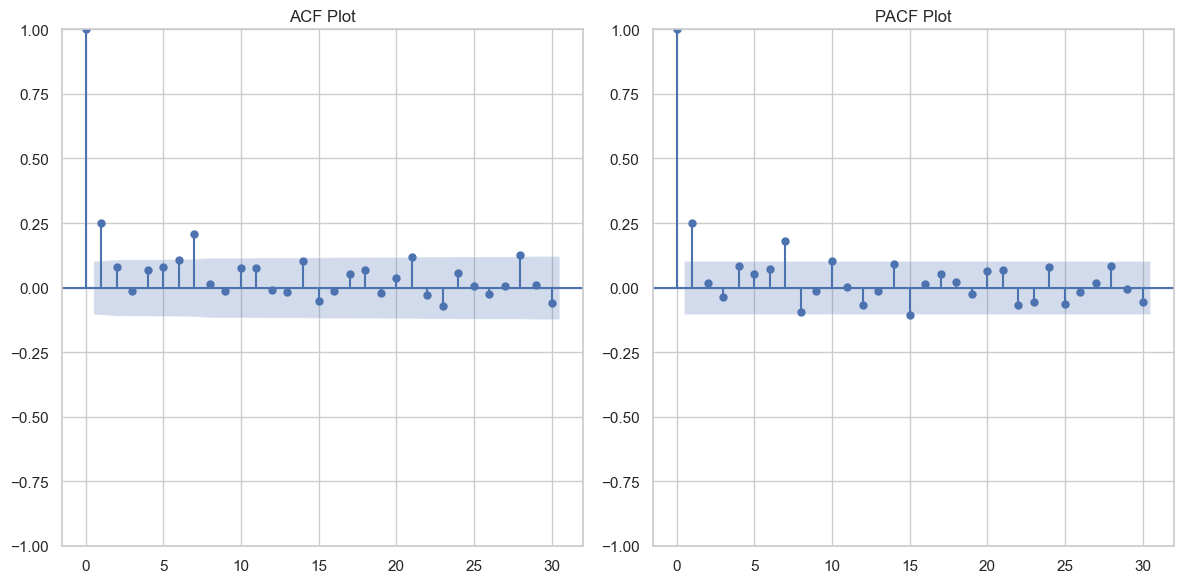

In [23]:
arima_analysis.plot_acf_pacf(30, 30) # pacf lags need to be less than half of the total observations (12) 11, 5
plt.show()

ACF Plot: This plot shows the correlation between the series and its lags.
* The cutoff point indicates the value for q, the order of the MA term (Moving Average). Where the autocorrelation becomes negligible (near zero). 
* If the ACF decays slowly, this suggests a higher order for q. If it cuts off sharply after a few lags, suggests a lower order for q.

PACF Plot: This plot shows the partial correlation of the series with its lags, controlling for the effect of earlier lags.
* Look for the cutoff point in the PACF plot. The lag where the PACF cuts off suggests the AR order (p).
* If the PACF cuts off after lag k, this suggests that p = k (i.e., the AR model only needs k previous values).
* If the PACF decays gradually, you may need a higher order for p.

#### **6.3. Fitting the ARIMA Model**

* d=0, it means no differencing has been applied to the data, and therefore the original data is considered stationary. 
* Even if the data is stationary based on the ADF test, some residual trend could still cause problems for the AR and MA parameter estimation when d=0.

C:\Testing\Anaconda\envs\dtsc\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:        total_dep_delay   No. Observations:                  181
Model:                 ARIMA(3, 1, 5)   Log Likelihood               -1173.007
Date:                Mon, 06 Jan 2025   AIC                           2364.015
Time:                        17:06:19   BIC                           2392.751
Sample:                    01-01-2023   HQIC                          2375.666
                         - 06-30-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8000      0.254     -3.145      0.002      -1.299      -0.301
ar.L2         -1.1432      0.121     -9.440      0.000      -1.381      -0.906
ar.L3         -0.3550      0.259     -1.372      0.1

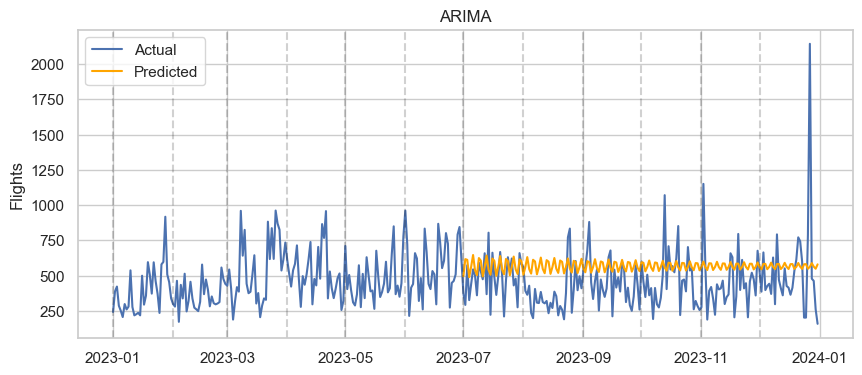

Mean Absolute Error (MAE): 177.21min.
Mean Absolute Percent Error (MAPE): 51.06%
Root Mean Squared Error (RMSE): 232.21min.


In [24]:
arima_test_data, arima_predictions, arima_residuals, arima_model = arima_analysis.arima_sarimax_forecast(order=(3, 1, 5)) #3, 1, 3 or 2, 1, 3
arima_mae, arima_mape, arima_rmse = evaluate_model(arima_test_data, arima_predictions, arima_residuals)

**Warning [2]. Covariance matrix is singular or near-singular.**
* Some parameters might be highly correlated.
* The model may have overfitting.
* The dataset doesn't have enough observations to support the model's complexity.

**our_model.mle_retvals** provides detailed information about the **Maximum Likelihood Estimation (MLE)** process for ARIMA.
* fopt: The optimized objective function value. This value looks **reasonable** and suggests that the model minimized the likelihood function **successfully**.
* gopt: The gradient of the objective function at the solution. The values are **close to zero**, indicating a **good fit** at the optimization's end.
* fcalls: The number of function calls made. A high number, combined with a failure to converge, indicates **the optimizer struggled to find a solution**.
* warnflag: A warning flag indicating the status of the optimization:
    * **0: Convergence was successful.**
    * 1: Maximum iterations were exceeded.
    * 2: Other issues prevented convergence.
* converged: A boolean flag indicating whether the optimization converged. True confirms that **convergence was achieved**.
* iterations: The number of iterations performed by the optimizer. The optimizer stopped because it found a solution (111) before reaching the maxiter limit (500).

#### **6.4. Fitting the SARIMAX Model**

                                     SARIMAX Results                                      
Dep. Variable:                    total_dep_delay   No. Observations:                  181
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 30)   Log Likelihood               -1020.134
Date:                            Mon, 06 Jan 2025   AIC                           2048.267
Time:                                    17:06:21   BIC                           2060.336
Sample:                                01-01-2023   HQIC                          2053.170
                                     - 06-30-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6176      0.166      3.724      0.000       0.293       0.943
ma.L1         -0.2738      0.230   

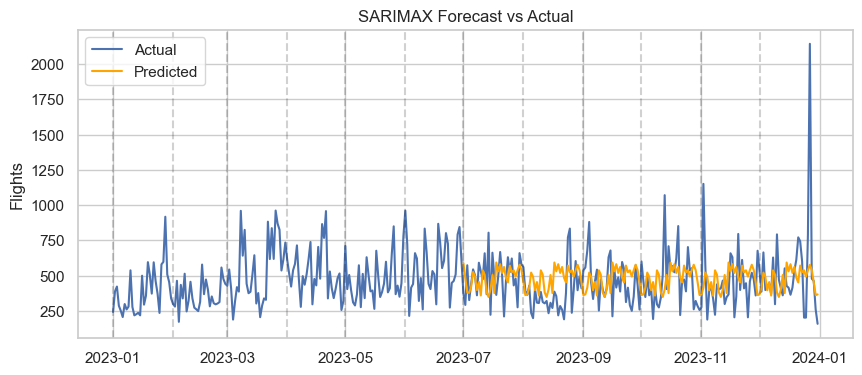

Mean Absolute Error (MAE): 151.19min.
Mean Absolute Percent Error (MAPE): 39.64%
Root Mean Squared Error (RMSE): 219.45min.


In [25]:
sarimax_test_data, sarimax_predictions, sarimax_residuals, sarimax_model = arima_analysis.arima_sarimax_forecast(order=(1, 0, 1), seasonal_order=(0, 1, 1, 30))
sarimax_mae, sarimax_mape, sarimax_rmse = evaluate_model(sarimax_test_data, sarimax_predictions, sarimax_residuals)

#### **6.5. Rolling Forecast Origin**
Instead of trying to predict 30 or more days right away, it predicts just one, and then it takes into account its real value, and then it predicts the nest one, and so on.

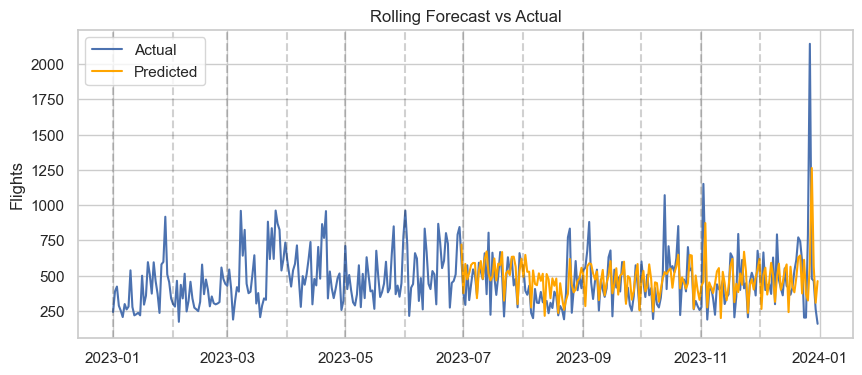

Mean Absolute Error (MAE): 133.15min.
Mean Absolute Percent Error (MAPE): 31.50%
Root Mean Squared Error (RMSE): 204.70min.


In [26]:
rolling_actual, rolling_predictions, rolling_residuals = arima_analysis.rolling_forecast(
    order=(1, 1, 1), train_window=180, seasonal_order=(0, 1, 1, 7)
)
rolling_mae, rolling_mape, rolling_rmse = evaluate_model(rolling_actual, rolling_predictions, rolling_residuals)

### **7. Neural Networks**

#### **Min-Max Scaling**
**Purpose**: To scale features so that they lie within a specific range, typically [0, 1] or [-1, 1].

**How it works**: The formula for normalization is:

    Xnorm = (X − Xmin) / (Xmax - Xmin)

where:

    X is the feature value,
    Xmin is the minimum value of the feature,
    Xmax is the maximum value of the feature.

**When to use**:
* To bound features to a specific range, especially if the model is sensitive to the magnitude of the input values, like neural networks or k-NN.
* It is sensitive to outliers, as the presence of extreme values can skew the results.

Epoch 1/50
1874/1874 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - loss: 0.0049 - val_loss: 3.8294e-04
Epoch 2/50
1874/1874 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - loss: 0.0011 - val_loss: 3.7932e-04
Epoch 3/50
1874/1874 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - loss: 8.2887e-04 - val_loss: 3.8944e-04
Epoch 4/50
1874/1874 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - loss: 7.0927e-04 - val_loss: 3.8190e-04
Epoch 5/50
1874/1874 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - loss: 7.1824e-04 - val_loss: 3.9270e-04
Epoch 6/50
1874/1874 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - loss: 7.1420e-04 - val_loss: 3.8159e-04
Epoch 7/50
1874/1874 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - loss: 7.1475e-04 - val_loss: 3.8690e-04
Epoch 8/50
1874/1874 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 7.0893e-04 - val_loss: 3.8932e-04
Epoch 9/50
1874/1874 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - loss: 7.0619e-04 - val_loss: 3.9718e-04
Epoch 10/50
1874/1874 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 7.0628e-04 - val_loss: 4.3521e-04
Epoch 11/50
1874/1874 ━━━━━━━━

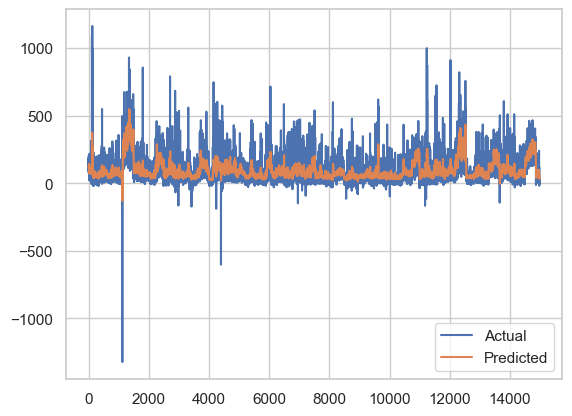

Mean Absolute Error (MAE): 47.90min.
Mean Absolute Percent Error (MAPE): inf%
Root Mean Squared Error (RMSE): 73.08min.


C:\4.DTSC_Programs\4.TransStatsData\AvStats\avstats\core\ML_workflow\ModelEvaluation.py:77: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(abs(residuals / test_data)) * 100 if residuals is not None else None


In [27]:
# Create an instance of NeuralNetworks
nn = NeuralNetworks(df_weather)

# Call the neural_networks method and unpack the returned values
nn_actual, nn_predictions = nn.neural_networks()

# Calculate residuals
non_zero_actual = nn_actual[nn_actual != 0]
non_zero_predictions = nn_predictions[nn_actual != 0]  # Match indices with non-zero actual
nn_residuals = nn_actual - nn_predictions

# Evaluate metrics
nn_mae, nn_mape, nn_rmse = evaluate_model(nn_actual, nn_predictions, nn_residuals)

### **8. Model Comparisons**

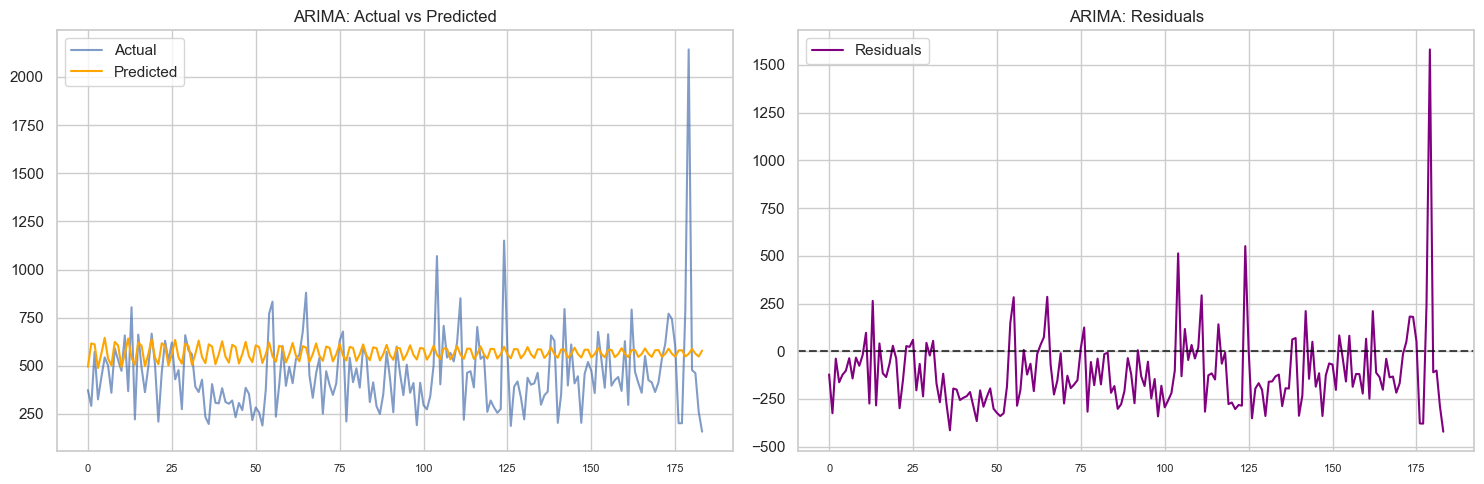

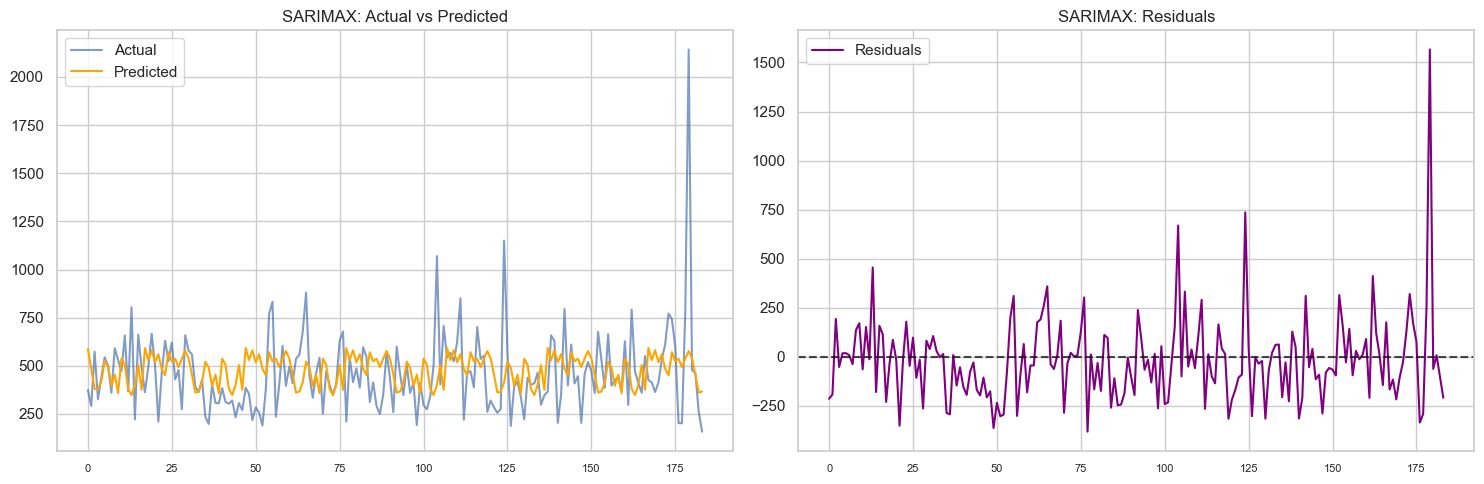

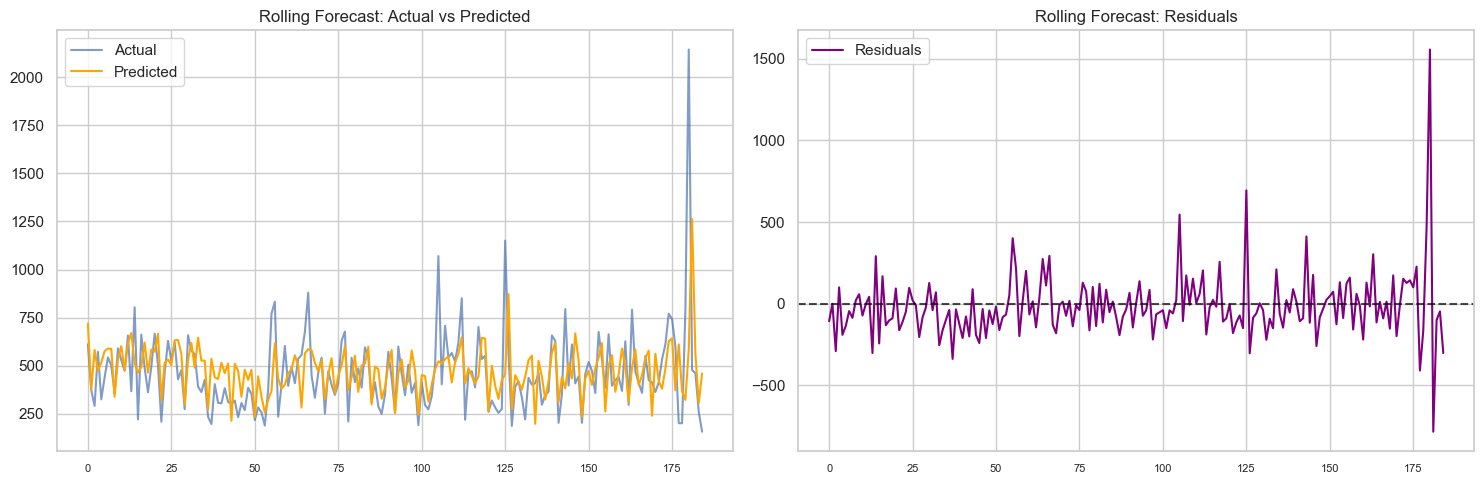

In [28]:
# Store evaluation results
evaluation_results = []

# Linear Regression
evaluation_results.append({"Model": "Linear Regression", **{"MAE (min.)": linear_mae, "MAPE (%)": linear_mape, "RMSE (min.)": linear_rmse}})
evaluation_results.append({"Model": "Decision Tree", **{"MAE (min.)": decision_mae, "MAPE (%)": decision_mape, "RMSE (min.)": decision_rmse}})
evaluation_results.append({"Model": "Random Forest", **{"MAE (min.)": random_forest_mae, "MAPE (%)": random_forest_mape, "RMSE (min.)": random_forest_rmse}})

# ARIMA
arima_eval = ModelComparison(arima_test_data, arima_predictions, arima_residuals)
arima_metrics = arima_eval.evaluate_metrics()
evaluation_results.append({"Model": "ARIMA", **arima_metrics})
arima_eval.plot_combined("ARIMA")

# SARIMAX
sarimax_eval = ModelComparison(sarimax_test_data, sarimax_predictions, sarimax_residuals)
sarimax_metrics = sarimax_eval.evaluate_metrics()
evaluation_results.append({"Model": "SARIMAX", **sarimax_metrics})
sarimax_eval.plot_combined("SARIMAX")

# Rolling Forecast Origin
rolling_eval = ModelComparison(rolling_actual, rolling_predictions, rolling_residuals)
rolling_metrics = rolling_eval.evaluate_metrics()
evaluation_results.append({"Model": "Rolling Forecast", **rolling_metrics})
rolling_eval.plot_combined("Rolling Forecast")

evaluation_results.append({"Model": "Neural Networks", **{"MAE (min.)": nn_mae, "MAPE (%)":nn_mape, "RMSE (min.)": nn_rmse}})

# Combine Results into a DataFrame
evaluation_df = pd.DataFrame(evaluation_results)

In [29]:
evaluation_df

,Model,MAE (min.),MAPE (%),RMSE (min.)
0,Linear Regression,620.801378,21.541116,844.904407
1,Decision Tree,969.712797,38.612251,1368.762164
2,Random Forest,631.339013,20.812623,874.941235
3,ARIMA,177.208463,51.058420,232.213299
4,SARIMAX,151.193856,39.643802,219.446912
5,Rolling Forecast,133.152406,31.501438,204.697535
6,Neural Networks,47.899953,inf,73.078314


* MAE gives the average error in absolute terms (e.g., "minutes off"), without considering whether the prediction is too high or too low.
* RMSE penalizes larger errors more than smaller ones due to squaring the errors, making it sensitive to outliers.
* MAPE represents the average percentage error relative to the actual values. Lower MAPE means the model is making smaller relative errors.

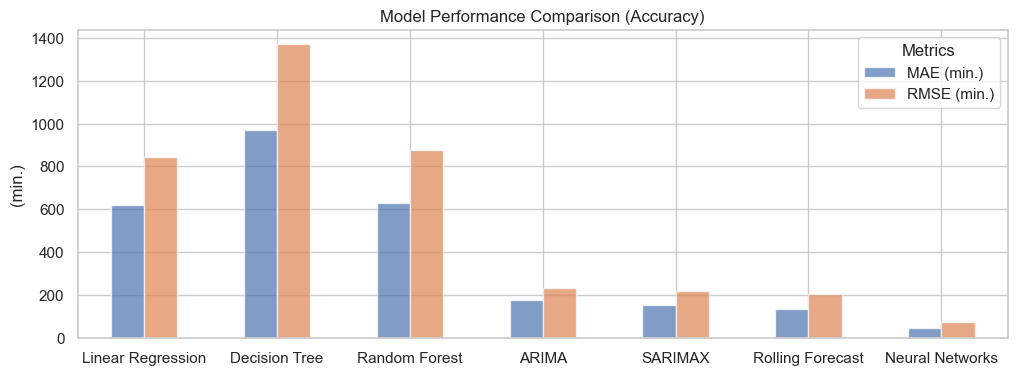

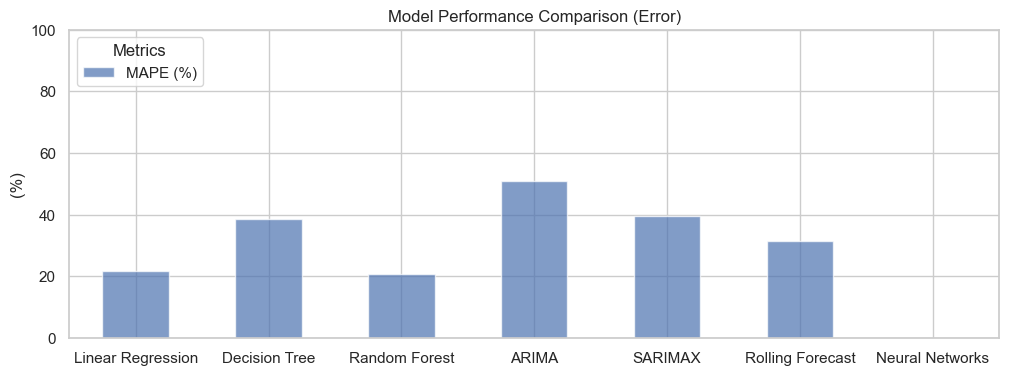

In [30]:
# Separate MAE, RMSE, and MAPE for plotting
evaluation_data = evaluation_df.set_index('Model')

# Plot MAE and RMSE (Minutes)
evaluation_data[['MAE (min.)', 'RMSE (min.)']].plot(kind='bar', figsize=(12, 4), alpha=0.7)
plt.title('Model Performance Comparison (Accuracy)')
plt.ylabel('(min.)')
plt.xlabel('')
plt.xticks(rotation=0, horizontalalignment='center')  # Rotate labels for better readability
plt.legend(title="Metrics")
plt.show()

# Plot MAPE (Percentage)
ax = evaluation_data[['MAPE (%)']].plot(kind='bar', figsize=(12, 4), alpha=0.7)
plt.title('Model Performance Comparison (Error)')
plt.ylabel('(%)')
plt.xlabel('')
plt.ylim(0, 100)  # Set y-axis range from 0 to 100
plt.xticks(rotation=0, horizontalalignment='center')  # Rotate labels for better readability
plt.legend(title="Metrics")
plt.show()

Predictions for all the routes (using passenger data)
* Linear Regression (best)
* Decision Tree
* Random Forest

Predictions for all the routes (without passenger data)
* Neural Networks

Predictions in 1 route (BRU-MAD)
* ARIMA
* SARIMAX
* Rolling Forecast (best)


Answer question: why these models and what learns faster

### **9. Residual Analysis**
* **Calculate residuals**: The differences between the actual and predicted values.
* **Linearity**: They should show no clear pattern when plotted against fitted values.
* **Normality**: They should follow a normal distribution (with Q-Q plot or histogram).
* **Autocorrelation**: They should not show autocorrelation (check with Durbin-Watson or ACF).
* **Homoscedasticity**: They should have constant variance (no funnel shapes).

In [31]:
plt.figure(figsize=(12, 8))  

# Linear Regression - Residual Analysis
linear_residuals = ResidualAnalysis(linear_model, linear_predictions, linear_residuals)
linear_residuals.plot_residuals("Linear Regression", subplot_position=(2, 2, 1))

# Random Forest - Residual Analysis
random_forest_residuals = ResidualAnalysis(random_forest_model, random_forest_predictions, random_forest_residuals)
random_forest_residuals.plot_residuals("Random Forest", subplot_position=(2, 2, 2))

plt.tight_layout()
plt.show()

ValidationError: 2 validation errors for ResidualAnalysisInput
model
  Input should be a valid string [type=string_type, input_value=<statsmodels.regression.l...t at 0x000002D915C7A9A0>, input_type=RegressionResultsWrapper]
    For further information visit https://errors.pydantic.dev/2.10/v/string_type
residuals
  Value error, residuals must be an instance of numpy.ndarray [type=value_error, input_value=408    1704.383960
97    ...gth: 152, dtype: float64, input_type=Series]
    For further information visit https://errors.pydantic.dev/2.10/v/value_error

<Figure size 1200x800 with 0 Axes>

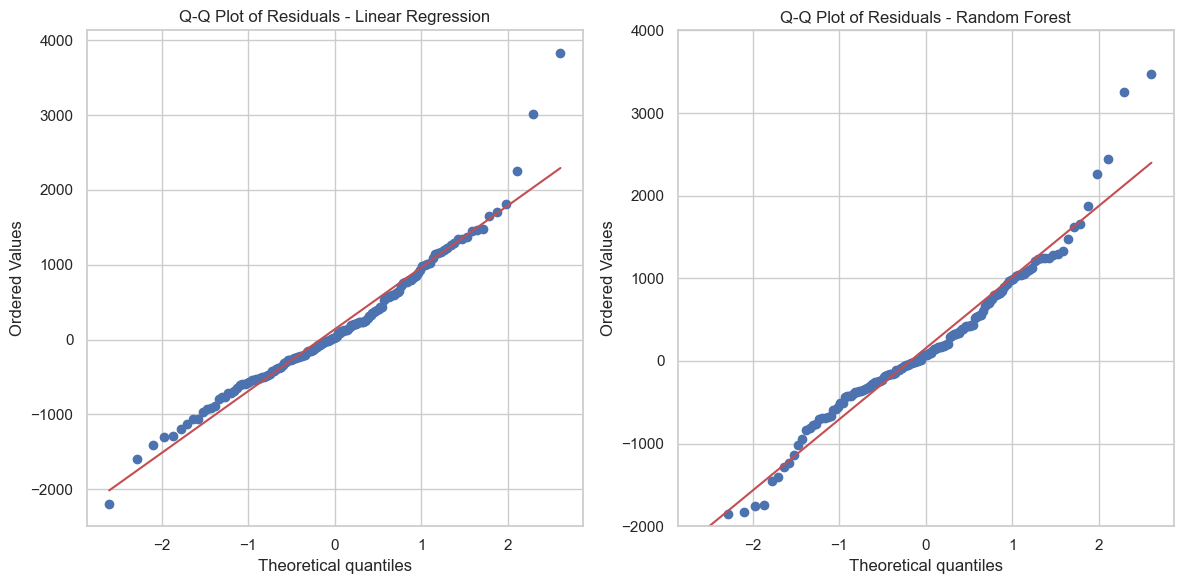

In [93]:
plt.figure(figsize=(12, 6))

linear_residuals.q_q_normality("Linear Regression", subplot_position=(1, 2, 1))
random_forest_residuals.q_q_normality("Random Forest", subplot_position=(1, 2, 2))

plt.tight_layout()
plt.ylim(-2000, 4000)
plt.show()

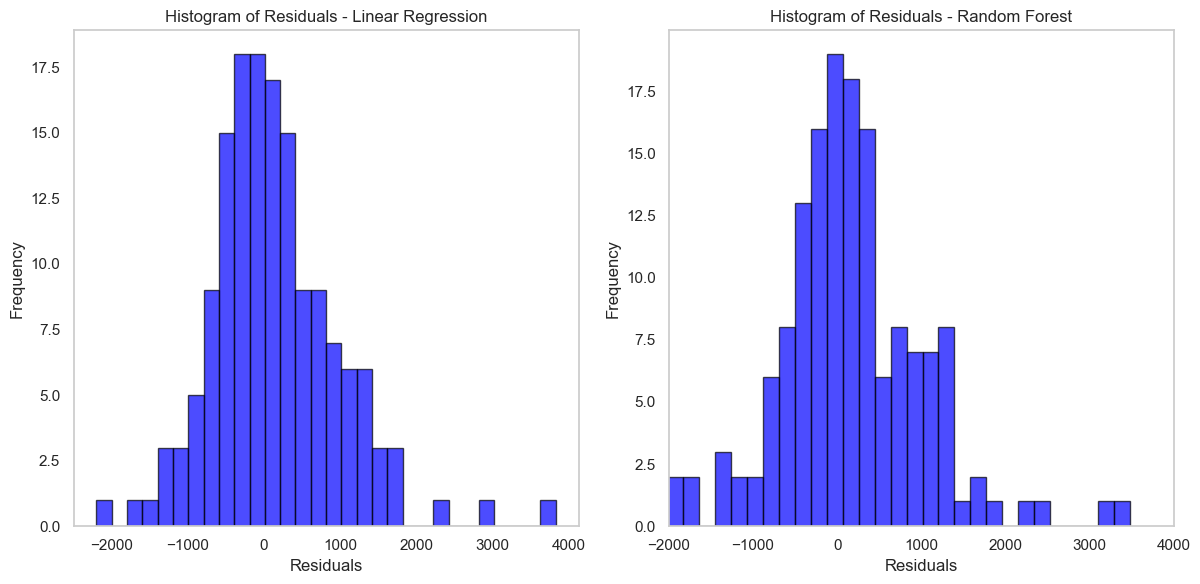

In [94]:
plt.figure(figsize=(12, 6))

linear_residuals.histogram_normality("Linear Regression", subplot_position=(1, 2, 1))
random_forest_residuals.histogram_normality("Random Forest", subplot_position=(1, 2, 2))

plt.tight_layout()
plt.xlim(-2000, 4000) 
plt.show()